Exploratory data analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile

In [2]:
def read_data(folder:str):
    dfs = []
    with ZipFile(folder + '.zip', 'r') as zip_ref:
        for f in zip_ref.namelist():
            print(f"Reading {f}...")
            with zip_ref.open(f) as file:
                df = pd.read_csv(file, parse_dates=['event_time'])
                dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

In [3]:
marketing_data = read_data('../data/archive')

Reading 2019-Dec.csv...
Reading 2019-Nov.csv...
Reading 2019-Oct.csv...
Reading 2020-Feb.csv...
Reading 2020-Jan.csv...


In [4]:
marketing_data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00+00:00,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00+00:00,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02+00:00,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05+00:00,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07+00:00,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5


In [5]:
marketing_data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00+00:00,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00+00:00,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02+00:00,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05+00:00,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07+00:00,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5


In [6]:
# Check event types
marketing_data['event_type'].value_counts()

event_type
view                9657821
cart                5768333
remove_from_cart    3979679
purchase            1287007
Name: count, dtype: int64

In [7]:
remove_from_cart_users

NameError: name 'remove_from_cart_users' is not defined

In [ ]:
# Check unique users from remove_from_cart event to purchase event
remove_from_cart_user_id = set(marketing_data[(marketing_data.event_type == "remove_from_cart")]['user_id'])
purchase_user_id = set(marketing_data[(marketing_data.event_type == "purchase")]['user_id'])

if remove_from_cart_user_id.intersection(purchase_user_id):
    print("Some users who removed from cart went on to purchase.")
else:
    print("No users who removed from cart went on to purchase.")

Some users who removed from cart went on to purchase.


In [ ]:
# Check basic funnel: total unique users vs unique purchasers
total_users = marketing_data['user_id'].nunique()
unique_purchasers = marketing_data[marketing_data['event_type'] == 'purchase']['user_id'].nunique()
print(f"Total unique users: {total_users}")
print(f"Unique purchasers: {unique_purchasers}")
print(f"Purchase rate: {unique_purchasers / total_users:.2%}")

Total unique users: 1639358
Unique purchasers: 110518
Purchase rate: 6.74%


### Retention curve

In [ ]:
# Cohort analysis - cohort by first event time
marketing_data['event_date'] = marketing_data['event_time'].dt.date
marketing_data = marketing_data.sort_values(by=['user_id', 'event_date'])
first_event = marketing_data.groupby('user_id')['event_date']\
    .min()\
    .reset_index()\
    .rename(columns={'event_date': 'cohort_date'})
marketing_data = marketing_data.merge(first_event, on='user_id')

marketing_data['cohort_period'] = (marketing_data['event_date'] - marketing_data['cohort_date'])\
                                    .apply(lambda x: x.days // 30)  # monthly cohorts

cohort_data = marketing_data.groupby(['cohort_date', 'cohort_period'])['user_id']\
    .nunique()\
    .reset_index()
cohort_pivot = cohort_data.pivot(index='cohort_date', columns='cohort_period', values='user_id')
cohort_pivot

cohort_period,0,1,2,3,4,5
cohort_date,,,,,,
2019-10-01,19230.0,3813.0,3027.0,2551.0,2357.0,489.0
2019-10-02,31739.0,2967.0,2244.0,2008.0,1878.0,160.0
2019-10-03,13356.0,2453.0,1791.0,1647.0,1523.0,NaN
2019-10-04,11438.0,1911.0,1444.0,1316.0,1163.0,NaN
2019-10-05,11997.0,1614.0,1131.0,1098.0,889.0,NaN
...,...,...,...,...,...,...
2020-02-25,10342.0,NaN,NaN,NaN,NaN,NaN
2020-02-26,10432.0,NaN,NaN,NaN,NaN,NaN
2020-02-27,10398.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# retention curve
cohort_pivot_norm = cohort_pivot.divide(cohort_pivot.iloc[:,0], axis=0)

In [ ]:
cohort_pivot_norm.head(10)

cohort_period,0,1,2,3,4,5
cohort_date,,,,,,
2019-10-01,1.0,0.198284,0.157410,0.132657,0.122569,0.025429
2019-10-02,1.0,0.093481,0.070702,0.063266,0.059170,0.005041
2019-10-03,1.0,0.183663,0.134097,0.123315,0.114031,NaN
2019-10-04,1.0,0.167075,0.126246,0.115055,0.101679,NaN
2019-10-05,1.0,0.134534,0.094274,0.091523,0.074102,NaN
2019-10-06,1.0,0.062516,0.046249,0.044562,0.035082,NaN
2019-10-07,1.0,0.104272,0.069942,0.068796,0.054359,NaN
2019-10-08,1.0,0.120317,0.083639,0.082919,0.064383,NaN
2019-10-09,1.0,0.142326,0.095478,0.094626,0.070698,NaN


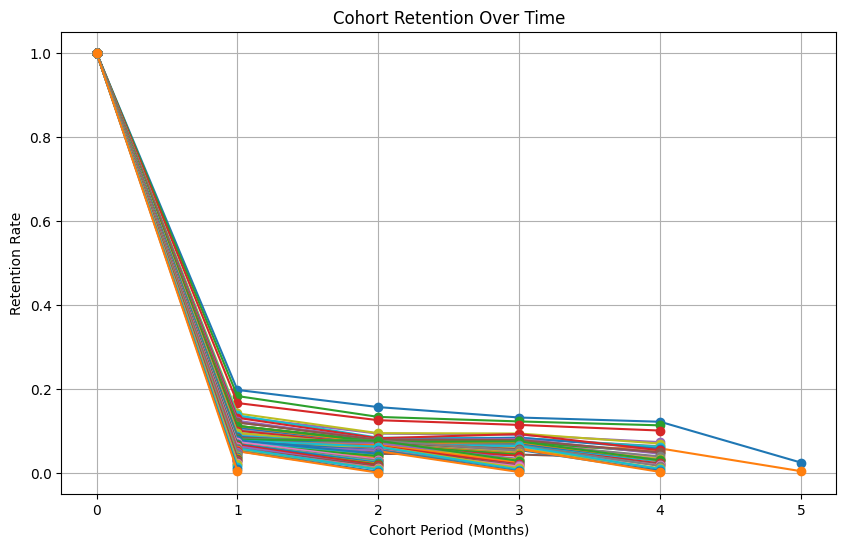

In [ ]:
plt.figure(figsize=(10, 6))
for i in cohort_pivot_norm.index:  # plot all cohorts
    plt.plot(cohort_pivot_norm.columns, cohort_pivot_norm.loc[i], marker='o', label=str(i))
#plt.legend()
plt.title('Cohort Retention Over Time')
plt.xlabel('Cohort Period (Months)')
plt.ylabel('Retention Rate')
plt.grid()
plt.show()

Retention of users drop to 20% after first month

### Simple funnel chart

In [ ]:
view_users = marketing_data[marketing_data['event_type'] == 'view']['user_id'].unique()
cart_users = marketing_data[marketing_data['event_type'] == 'cart']['user_id'].unique()
purchase_users = marketing_data[marketing_data['event_type'] == 'purchase']['user_id'].unique()
remove_from_cart_users = marketing_data[marketing_data['event_type'] == 'remove_from_cart']['user_id'].unique()

In [ ]:
funnel_dict = { 
    "Stage": ['view', 'cart', 'remove_from_cart', 'purchase'],
    "Users": [len(view_users), len(cart_users), len(remove_from_cart_users), len(purchase_users)]
}

funnel_df = pd.DataFrame.from_dict(funnel_dict)
funnel_df

,Stage,Users
0,view,1597754
1,cart,398308
2,remove_from_cart,183232
3,purchase,110518


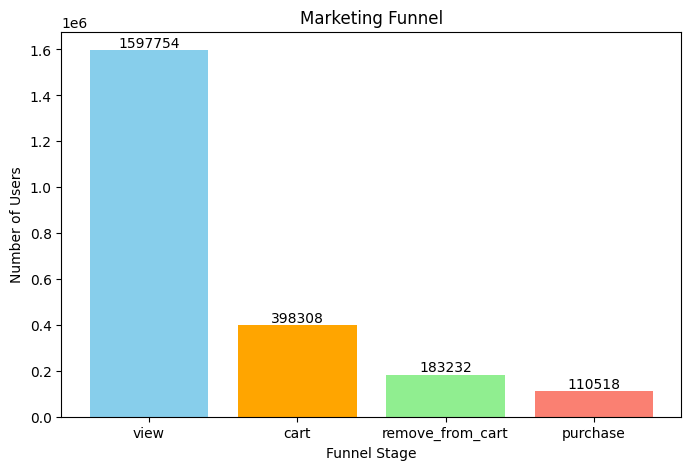

In [ ]:
plt.figure(figsize=(8, 5))
bars = plt.bar(funnel_df['Stage'], funnel_df['Users'], color=['skyblue', 'orange', 'lightgreen', 'salmon']) 
plt.title('Marketing Funnel')
plt.xlabel('Funnel Stage')
plt.ylabel('Number of Users')

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, str(yval), ha='center', va='bottom')

plt.show()

In [ ]:
import plotly.express as px
fig = px.funnel(funnel_df, x='Users', y='Stage', color='Stage', title='Marketing Funnel')
fig.show()

In [9]:
view_set = set(marketing_data[marketing_data.event_type == "view"]['user_id'])
cart_set = set(marketing_data[marketing_data.event_type == "cart"]['user_id'])
remove_from_cart_set = set(marketing_data[marketing_data.event_type == "remove_from_cart"]['user_id'])
purchase_set = set(marketing_data[marketing_data.event_type == "purchase"]['user_id'])

view_to_cart_flow = len(cart_set.intersection(view_set))
cart_to_purchase_flow = len(purchase_set.intersection(cart_set))
cart_to_remove_from_cart_flow = len(remove_from_cart_set.intersection(cart_set))
remove_from_cart_to_purchase_flow = len(purchase_set.intersection(remove_from_cart_set))
view_to_purchase_flow = len(purchase_set.intersection(view_set))

In [11]:
# Sankey plot for user journey
import plotly.graph_objects as go

labels = ["view", "cart", "remove_from_cart", "purchase"]

sources = [0, 1, 1, 2, 0]  
targets = [1, 2, 3, 3, 3] 
values = [view_to_cart_flow, 
          cart_to_remove_from_cart_flow, 
          cart_to_purchase_flow, 
          remove_from_cart_to_purchase_flow,
          view_to_purchase_flow]

fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=["#4C72B0", "#55A868", "#C44E52", "#8172B3"],
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        # color=["rgba(76,114,176,0.4)", "rgba(84,168,104,0.4)"]
    )
)])

fig.update_layout(title_text="User Flow Through Funnel (Sankey Diagram)", font_size=12)
fig.show()